In [1]:
import os
from glob import glob
from math import ceil, floor

import numpy as np
import pandas as pd
import cv2 as cv
from matplotlib import pyplot as plt

# Ground Truth Labels

In [2]:
gt = pd.read_csv('data/GaitDatasetB-gender.csv', delimiter='\t')
gt

,Subject ID,Gender,Height(cm)
0,1,M,176
1,2,M,174
2,3,M,161
3,4,M,168
4,5,M,175
...,...,...,...
119,120,M,177
120,121,F,168
121,122,M,181
122,123,M,165


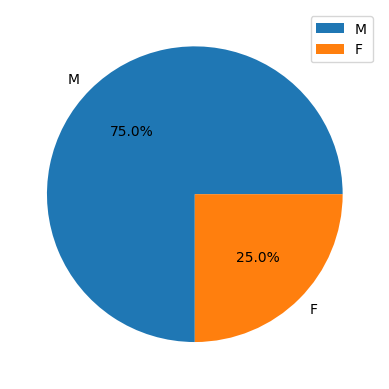

In [3]:
counts = gt['Gender'].value_counts()
plt.pie(counts, labels=['M', 'F'], autopct="%.1f%%")
plt.legend()
plt.show()
# plt.savefig('dataset-pie.png')

# Gait Preprocessing
## Cropping the Silhouette image

In [4]:
def crop(img, scale=False):
    '''
    Find the first non zero pixel from all 4 directions to crop the silhouette
    scale the image without changing aspect ratio to get 224 pixels in height
    and pad the remaining area to get fixed size 224 x 224 image
    '''

    rs1 = img.sum(axis=0)
    nz1 = rs1.nonzero()[0]
    if nz1.size == 0:
        return None
    y1, y2 = nz1[0], nz1[-1] + 1

    rs2 = img.sum(axis=1)
    nz2 = rs2.nonzero()[0]
    if nz2.size == 0:
        return None
    x1, x2 = nz2[0], nz2[-1] + 1
    cropped = img[x1:x2, y1:y2]

    if scale:
        scale_factor = 224 / cropped.shape[0]
        get_size = lambda x: min(224, ceil(x * scale_factor))
        new_size = tuple(map(get_size, cropped.shape))

        scaled = cv.resize(cropped, new_size[::-1])
        left = ceil((224 - new_size[1]) / 2)
        right = floor((224 - new_size[1]) / 2)
        pad = ((0, 0), (left, right))
        new_img = scaled
    else:
        left = ceil((224 - ( y2 - y1 )) / 2)
        right = floor((224 - (y2 - y1)) / 2)
        top = ceil((224 - (x2 - x1)) / 2)
        bottom = floor((224 - (x2 - x1)) / 2)
        pad = ((top, bottom), (left, right))
        new_img = cropped

    # return new_img
    return np.pad(new_img, pad)

(240, 320)


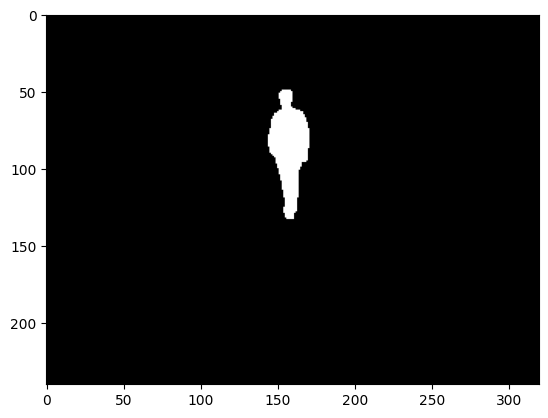

In [5]:
img = cv.imread('data/GaitDatasetB-silh/001/bg-01/000/001-bg-01-000-012.png', cv.IMREAD_UNCHANGED)
print(img.shape)
plt.imshow(img, cmap='gray')

(224, 224)


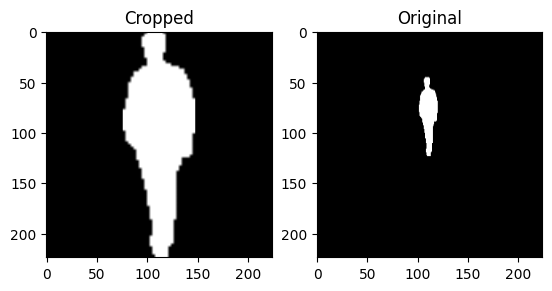

In [6]:
img_crop = crop(img, True)
print(img_crop.shape)
plt.subplot(1,2,1)
plt.imshow(img_crop, cmap='gray')
plt.title('Cropped')
plt.subplot(1,2,2)
plt.imshow(cv.resize(img, (224, 224)), cmap='gray')
plt.title('Original')
plt.show()

## Gait Energy Image preparation
### Multi Channel GEI

In [26]:
temp = np.zeros((224, 224))
prefix = 'data/GaitDatasetB-silh'
for pid in range(1, 125):
    person_id = str(pid).zfill(3)
    print('person:', person_id)
    for t in sorted(glob(os.path.join(prefix, person_id, '*/*'))):
        _, scene, angle = t.strip(prefix).split('/')
        gei = []
        # split the gait cycle into 3 channels of GEI
        for channel in np.array_split(sorted(glob(os.path.join(t, '*.png'))), 3):
            for x in channel:
                img = cv.imread(x, cv.IMREAD_UNCHANGED)
                y = crop(img, True)
                if y is not None:
                    temp += y
        
            temp /= channel.size
            gei.append(temp.copy())
            temp = np.zeros((224, 224))
        
        new_id = '_'.join([person_id, scene, angle])
        gei = np.moveaxis(np.array(gei), 0, -1)

        cv.imwrite(os.path.join('data/GEI', new_id + '.png'), gei)

person: 001
person: 002
person: 003
person: 004
person: 005


/tmp/ipykernel_6683/1385295598.py:17: RuntimeWarning: invalid value encountered in divide
  temp /= channel.size


person: 006
person: 007
person: 008
person: 009
person: 010
person: 011
person: 012
person: 013
person: 014
person: 015
person: 016
person: 017
person: 018
person: 019
person: 020
person: 021
person: 022
person: 023
person: 024
person: 025
person: 026
person: 027
person: 028
person: 029
person: 030
person: 031
person: 032
person: 033
person: 034
person: 035
person: 036
person: 037
person: 038
person: 039
person: 040
person: 041
person: 042
person: 043
person: 044
person: 045
person: 046
person: 047
person: 048
person: 049
person: 050
person: 051
person: 052
person: 053
person: 054
person: 055
person: 056
person: 057
person: 058
person: 059
person: 060
person: 061
person: 062
person: 063
person: 064
person: 065
person: 066
person: 067
person: 068
person: 069
person: 070
person: 071
person: 072
person: 073
person: 074
person: 075
person: 076
person: 077
person: 078
person: 079
person: 080
person: 081
person: 082
person: 083
person: 084
person: 085
person: 086
person: 087
person: 088
pers

### Single channel GEI

In [49]:
temp = np.zeros((224, 224))
prefix = 'data/GaitDatasetB-silh'
for pid in range(1, 125):
    person_id = str(pid).zfill(3)
    print('person:', person_id)
    for t in sorted(glob(os.path.join(prefix, person_id, '*/*'))):
        _, scene, angle = t.strip(prefix).split('/')
        gei = []
        for channel in np.array_split(sorted(glob(os.path.join(t, '*.png'))), 1):
            for x in channel:
                img = cv.imread(x, cv.IMREAD_UNCHANGED)
                y = crop(img, True)
                if y is not None:
                    temp += y
        
            temp /= channel.size
            gei.append(temp.copy())
            temp = np.zeros((224, 224))
        
        new_id = '_'.join([person_id, scene, angle])
        gei = np.moveaxis(np.array(gei), 0, -1)
        gei = np.array(gei)

        cv.imwrite(os.path.join('data/GEI_1', new_id + '.png'), gei)

person: 001
person: 002
person: 003
person: 004
person: 005


/tmp/ipykernel_6683/1193315139.py:16: RuntimeWarning: invalid value encountered in divide
  temp /= channel.size


person: 006
person: 007
person: 008
person: 009
person: 010
person: 011
person: 012
person: 013
person: 014
person: 015
person: 016
person: 017
person: 018
person: 019
person: 020
person: 021
person: 022
person: 023
person: 024
person: 025
person: 026
person: 027
person: 028
person: 029
person: 030
person: 031
person: 032
person: 033
person: 034
person: 035
person: 036
person: 037
person: 038
person: 039
person: 040
person: 041
person: 042
person: 043
person: 044
person: 045
person: 046
person: 047
person: 048
person: 049
person: 050
person: 051
person: 052
person: 053
person: 054
person: 055
person: 056
person: 057
person: 058
person: 059
person: 060
person: 061
person: 062
person: 063
person: 064
person: 065
person: 066
person: 067
person: 068
person: 069
person: 070
person: 071
person: 072
person: 073
person: 074
person: 075
person: 076
person: 077
person: 078
person: 079
person: 080
person: 081
person: 082
person: 083
person: 084
person: 085
person: 086
person: 087
person: 088
pers

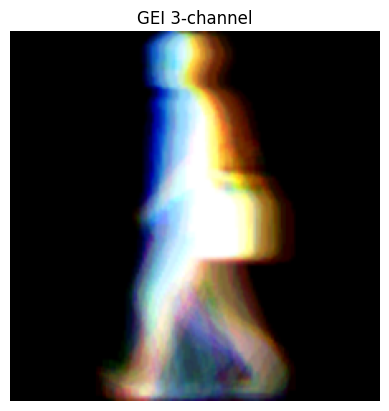

In [7]:
img2 = cv.imread('data/GEI/001_bg-01_090.png')
plt.imshow(img2)
plt.title('GEI 3-channel')
plt.axis('off')
# plt.savefig('gei3.png')
plt.show()

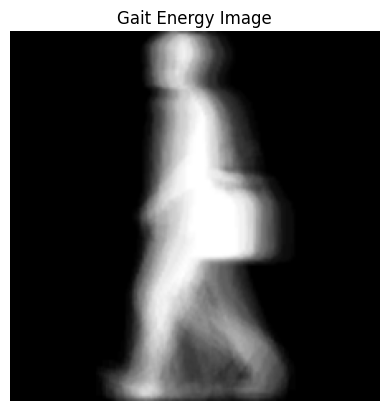

In [8]:
img3 = cv.imread('data/GEI_1/001_bg-01_090.png')
plt.imshow(img3)
plt.title('Gait Energy Image')
plt.axis('off')
# plt.savefig('gei.png')
plt.show()